In [75]:
import torch
from torch import nn
from datasets import load_dataset
import fastcore.all as fc
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, default_collate
from torch import optim

In [76]:
import matplotlib.pyplot as plt
import wandb
wandb.init(
    project='vae'
)
plt.rcParams['image.cmap'] = 'gray'

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▂▂▃▄▄▅▅▆▇▇██▁▂▂▃▄▄▅▅▆▇▇██▁▂▂▃▄▄▅▅▆▆▇▇█
loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂
epoch,20
loss,0.02628
train,eval


In [77]:
name = 'fashion_mnist'
x,y = 'image','label'
dsr = load_dataset(name)

Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
100%|██████████| 2/2 [00:00<00:00, 39.20it/s]


In [78]:
def transform(b):
    b[x] = [TF.to_tensor(ele)-0.5 for ele in b[x]]
    return b

In [79]:
dst = dsr.with_transform(transform)

In [80]:
def collate_dict(b):
     clt = default_collate(b)
     return (clt[x], clt[y])

class DataLoaders:
     def __init__(self, train_ds, valid_ds, batch_size, collate_fn, **kwargs):
          self.train = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, **kwargs)
          self.valid = DataLoader(valid_ds, batch_size=batch_size*2, collate_fn=collate_fn, shuffle=True, **kwargs)

In [81]:
bs = 1024
dls = DataLoaders(dst['train'], dst['test'], batch_size=bs, collate_fn=collate_dict)

In [82]:
xb,yb = next(iter(dls.train))
xb.shape, yb.shape, xb.min(), xb.max()

(torch.Size([1024, 1, 28, 28]),
 torch.Size([1024]),
 tensor(-0.5000),
 tensor(0.5000))

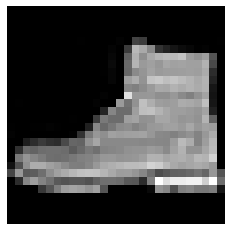

In [83]:
plt.imshow(xb[2].permute(1, 2, 0));
plt.axis('off');

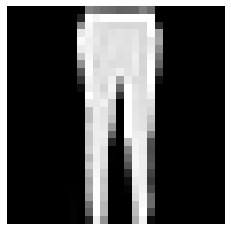

In [84]:
plt.imshow(xb[5].permute(1, 2, 0));
plt.axis('off');

In [85]:
def conv(ni, nf, ks=3, s=2, act=nn.ReLU, norm=None, bias=True):
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, stride=s, padding=ks//2, bias=bias)]
    if norm is not None:
        layers.append(norm)
    if act:
        layers.append(act())
    return nn.Sequential(*layers)

def _conv_block(ni, nf, ks=3, s=2, act=nn.ReLU, norm=None, bias=True):
    return nn.Sequential(
        conv(ni, nf, ks=ks, s=1, act=act, bias=bias),
        conv(nf, nf, s=s, norm=norm, act=None, bias=bias)
    )

class ResBlock(nn.Module):
    def __init__(self, ni, nf, ks=3, s=2, act=nn.ReLU, norm=None, bias=True):
        super().__init__()
        self.conv = _conv_block(ni, nf, ks=ks, s=s, act=act, norm=norm, bias=bias)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, s=1, ks=1, act=None)
        self.pool = nn.noop if s==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()
    
    def forward(self, x):
        return self.act(self.conv(x) + self.idconv(self.pool(x)))

In [86]:
def kaiming_init(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        nn.init.kaiming_normal_(m.weight)

In [87]:
class Reshape(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, x):
        return x.view(self.dim)

class RTanh(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        x = nn.Tanh()(x)

class VAEAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = self._encoder()
        self.decoder = self._decoder()
    
    def _encoder(self):
        return nn.Sequential(
            Reshape((-1, 28*28)),
            nn.Linear(784, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 96),
            nn.BatchNorm1d(96),
            nn.ReLU(),
            nn.Linear(96, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU())
    
    def _decoder(self):
        return nn.Sequential(
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 784),
            RTanh(),
            Reshape((-1, 1, 28, 28))
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [103]:
q = torch.distributions.MultivariateNormal(torch.tensor([0, 0, 0]), torch.eye(3))
p = torch.distributions.MultivariateNormal(torch.tensor([0, 0, 0]), torch.eye(3))
kl = torch.distributions.kl.kl_divergence(q, p)
kl

tensor(0.)

In [88]:
def noisify(xb):
    with torch.no_grad():
        z = torch.distributions.Normal(xb, 0.2)
        xb = z.sample((1,))[0]
    return xb

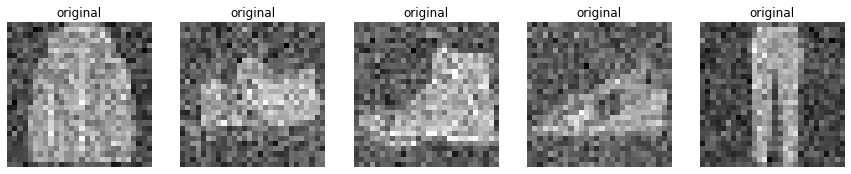

In [89]:
xbn = noisify(xb)
_,axs2 = plt.subplots(1, 5, figsize=(15, 15))
for img, ax in zip(xbn[:5], axs2.flat):
    ax.imshow(img.permute(1,2,0))
    ax.set_axis_off()
    ax.set_title('original')

In [68]:
model = AutoEncoder()
output = model(xb).detach().cpu()
output.shape
xb.min(),xb.max()

(tensor(-0.5000), tensor(0.5000))

In [73]:
epochs = 20
lr = 6e-2
model = AutoEncoder()
model.apply(kaiming_init)
opt = optim.AdamW(model.parameters(), lr=lr)
for epoch in range(epochs):
    for train in (True, False):
        dl = dls.train if train else dls.valid
        for xb,yb in dl:
            # xbn = noisify(xb)
            xbn = xb
            pred = model(xbn)
            loss = F.mse_loss(pred, xb)
            if train:
                loss.backward()
                opt.step()
                opt.zero_grad()
        wandb.log({
            'train': 'train' if train else 'eval',
            'epoch': epoch + 1,
            'loss': loss.item()
        })
        print(f"train: {'train' if train else 'eval'}, epoch:{epoch+1}, loss: {loss.item():.4f}")

train: train, epoch:1, loss: 0.0348
train: eval, epoch:1, loss: 0.0350
train: train, epoch:2, loss: 0.0305
train: eval, epoch:2, loss: 0.0312
train: train, epoch:3, loss: 0.0303
train: eval, epoch:3, loss: 0.0291
train: train, epoch:4, loss: 0.0295
train: eval, epoch:4, loss: 0.0303
train: train, epoch:5, loss: 0.0265
train: eval, epoch:5, loss: 0.0270
train: train, epoch:6, loss: 0.0260
train: eval, epoch:6, loss: 0.0267
train: train, epoch:7, loss: 0.0266
train: eval, epoch:7, loss: 0.0260
train: train, epoch:8, loss: 0.0265
train: eval, epoch:8, loss: 0.0263
train: train, epoch:9, loss: 0.0256
train: eval, epoch:9, loss: 0.0246
train: train, epoch:10, loss: 0.0253
train: eval, epoch:10, loss: 0.0274
train: train, epoch:11, loss: 0.0250
train: eval, epoch:11, loss: 0.0251
train: train, epoch:12, loss: 0.0244
train: eval, epoch:12, loss: 0.0245
train: train, epoch:13, loss: 0.0242
train: eval, epoch:13, loss: 0.0243
train: train, epoch:14, loss: 0.0248
train: eval, epoch:14, loss: 0.0

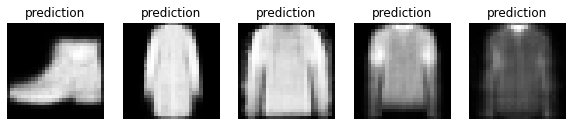

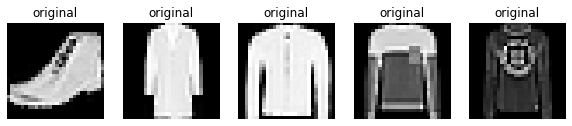

wandb: Network error (ConnectionError), entering retry loop.


In [74]:
outp = model(xb).detach()
sz = 5
imgs = outp[:sz]
imgs.shape
_,axs = plt.subplots(1, sz, figsize=(10, 10))
for img, ax in zip(imgs, axs.flat):
    ax.imshow(img.permute(1,2,0))
    ax.set_axis_off()
    ax.set_title('prediction')
    
_,axs2 = plt.subplots(1, sz, figsize=(10, 10))
for img, ax in zip(xb[:sz], axs2.flat):
    ax.imshow(img.permute(1,2,0))
    ax.set_axis_off()
    ax.set_title('original')

In [72]:
wandbpred= wandb.Image(
   outp[:20]
)
wandbinp= wandb.Image(
   xb[:20]
)
wandb.log({
    'generated': wandbpred,
    'original': wandbinp,
})